In [2]:
import pandas as pd
import os
from os import listdir, mkdir, path
from pathlib import Path
import sys
from email.parser import HeaderParser, BytesParser
import collections
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
from collections import Counter
from bs4 import BeautifulSoup
import html2text

In [3]:
parser = BytesParser()
header_parser = HeaderParser()
columns = ['received1',
'received2',
'received3',
'received4',
'received5',
'received6',
'received7',
'received8',
'received9',
'received10',
'received11',
'hops',
'subject',
'date',
'message-id',
'from',
'return-path',
'to',
'content-type',
'mime-version',
'content-transfer-encoding',
'content-length',
'delivered-to',
'sender',
'reply-to',
'references',
'in-reply-to',
'cc',
'received-spf',
'content-disposition',
'mailing-list',
'domainkey-signature',
'importance',
'label']

# List to store row dictionaries for headers
list_of_rows = []
# List to store email bodies
list_of_bodies = []
# Set to store seen emails
seen_emails = set()

In [4]:
def getTrecIndexMap(index_path, data_path):
    index = {}
    with open(index_path, encoding='us-ascii') as index_file:
        for i, line in enumerate(index_file):
            type = line[0:4]
            file_path = line.split('/')[2][:-1]
            if type == 'spam':
                index[f'{data_path}{file_path}'] = 1
            else:
                index[f'{data_path}{file_path}'] = 0
    return index

# Function to load .eml files from a folder
def load_safe_eml_files_from_folder(folder_path, index, start=2544, end=5088):
    train_eml_files = []
    test_eml_files = []
    count = 0
    
    # Traverse the directory tree
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if count > end:
                break
            file_path = os.path.join(root, file)

            # Check if the file exists in the index and append it
            if file_path in index and index[file_path] == 0:
                if start <= count <= end:
                    test_eml_files.append((file_path))  # Append a tuple of file path and label
                if count < start:
                    train_eml_files.append((file_path))
                count += 1
    
    return train_eml_files, test_eml_files

# Function to load .eml files from a PhishingPot folder
def load_phishingpot_files(folder_path):
    eml_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".eml"):
                eml_files.append(os.path.join(root, file))
    return eml_files

# Function to load emails from a Jose folder
def load_jose_files(folder_path):
    eml_files = []
    for filename in listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = path.join(folder_path, filename)
            emailStr = ''
            try:
                with open(file_path, encoding='latin_1') as emailFile:
                    for line in emailFile:
                        emailStr += line
            except UnicodeDecodeError:
                print(f'Unicode Error in file {file_path}!')
            
            email_list = emailStr.split('\nFrom jose@monkey.org')
            for email in email_list:
                eml_files.append(email)
    return eml_files

# Function to parse email and extract headers and body
def parse_eml_file(file_path, label, is_file=True):
    if is_file:
        with open(file_path, 'rb') as f:
            msg = parser.parse(f)
    else:
        msg = header_parser.parsestr(file_path)

    # Initialize the row dictionary
    row_dict = {}

    # Parse the email content
    h = msg

    # Parse recieved field
    received_list = h.get_all('received')
    hops = 0
    if received_list is not None:
        hops = len(received_list)
        col_name_recieved = 'received'

        for inx, received_field in enumerate(received_list):
            col = col_name_recieved + str(inx+1)
            row_dict[col] = received_field

    # Make everything lowercase to avoid issues
    features_lower_case = [x.lower() for x in h.keys()]

    # Parse everything else
    new_row = dict(zip(features_lower_case, h.values()))
    new_row['hops'] = hops

    for key, value in new_row.items():
        if key in columns:
            row_dict['label'] = label
            row_dict[key] = value

    # Extract the body (plain text or HTML)
    body = None
    if msg.is_multipart():
        for part in msg.walk():
            cdispo = str(part.get('Content-Disposition'))
            if part.get_content_type() == "text/plain" and 'attachment' not in cdispo:
                charset = part.get_content_charset() or 'utf-8'  # Fallback to 'utf-8' if charset is None
                try:
                    body = part.get_payload(decode=True).decode(charset, errors='ignore')
                except LookupError:
                    # If the charset is not recognized, fallback to 'utf-8'
                    body = part.get_payload(decode=True).decode('utf-8', errors='ignore')
                break
            elif part.get_content_type() == "text/html" and 'attachment' not in cdispo:
                # charset = part.get_content_charset() or 'utf-8'  # Fallback to 'utf-8' if charset is None
                # try:
                #     html_body = part.get_payload(decode=True).decode(charset, errors='ignore')
                # except LookupError:
                #     # If the charset is not recognized, fallback to 'utf-8'
                #     html_body = part.get_payload(decode=True).decode('utf-8', errors='ignore')
                # body = BeautifulSoup(html_body, 'html.parser').get_text()
                body = str(part.get_payload(decode=True))
                break
    else:
        charset = msg.get_content_charset() or 'utf-8'  # Fallback to 'utf-8' if charset is None
        try:
            body = msg.get_payload(decode=True).decode(charset, errors='ignore')
        except LookupError:
            # If the charset is not recognized, fallback to 'utf-8'
            body = msg.get_payload(decode=True).decode('utf-8', errors='ignore')

    if body:
            # Add the body to the row dictionary
            row_dict['body'] = body
    else:
        row_dict['body'] = 'No body'

    return row_dict

In [5]:
# Folder paths for safe and phishing emails
trec_folder = '../Data/trec07p/data/'
phishingpot_folder = '../Data/PhishingPotEmls'
jose_phishing_folder = '../Data/JosePhishingEmails/data'

trec_index = getTrecIndexMap('../Data/trec07p/full/index', '../Data/trec07p/data/')

# Load safe and phishing emails
train_safe_emails, test_safe_emails = load_safe_eml_files_from_folder(trec_folder, trec_index)
phishingpot_emails = load_phishingpot_files(phishingpot_folder)
jose_phishing_emails = load_jose_files(jose_phishing_folder)

# Parse each email and collect headers and body
trec_train_safe_data = []
trec_ensemble_safe_data = []
phishingpot_data = []
jose_phishing_data = []

for email_file in train_safe_emails:
    parsed_email = parse_eml_file(email_file, 0)
    trec_train_safe_data.append(parsed_email)

for email_file in test_safe_emails:
    parsed_email = parse_eml_file(email_file, 0)
    trec_ensemble_safe_data.append(parsed_email)

for email_file in phishingpot_emails:
    parsed_email = parse_eml_file(email_file, 1)
    phishingpot_data.append(parsed_email)

for email_file in jose_phishing_emails:
    parsed_email = parse_eml_file(email_file, 1, is_file=False)
    if parsed_email:
        jose_phishing_data.append(parsed_email)

b'![](\\'http://cmgr.netcontentinc.net/chandler/wb.aspx?cid=be066497-37fc-4dc7-a076-54e64aaf7995\\')\n\n\n\n\n\n

\n \n \n \n \n \n [\n
![](http://www.pmaconference.com/images/isda202header.gif)](\\'http://cmgr.netcontentinc.net/chandler/proxy.aspx?lid=35636114-538F-4928-9C6D-9CFCAF65323A\\')\n  
---  
\n \n \n **ISDA Master Agreements \n\t\t202** \n **\n\t\tJuly 19, 2007 -
Houston, TX** \n **\n\t\t -\n\t\t[Click Here To Register
Online](\\'http://cmgr.netcontentinc.net/chandler/proxy.aspx?lid=50C9CCC5-A3C4-44E5-83C2-78DADC8E310D\\')**\n
**\n\t\tSept. 20, 2007 - Philadelphia, PA \n\t\t- **\n **\n\t\t[Click Here To
Register
Online](\\'http://cmgr.netcontentinc.net/chandler/proxy.aspx?lid=2B6FB98F-9782-4978-A11D-FC52A93711A9\\')**\n
\n  
\n \n \n ![](http://www.pmaconference.com/imagesemail/id000221/line.gif)\n  
\n \n \n **\n \n [Click To \n Download A Complete Conference Brochure and
Order
Form](\\'http://cmgr.netcontentinc.net/chandler/proxy.aspx?lid=95487A2A-FF7D-4CEC-
AE4D-3E1E6C7FC

In [6]:
df_ensemble_safe_trec = pd.DataFrame(trec_ensemble_safe_data)
df_train_and_test_safe_trec = pd.DataFrame(trec_train_safe_data)
df_phishingpot = pd.DataFrame(phishingpot_data)
df_jose_phishing = pd.DataFrame(jose_phishing_data)

print(df_ensemble_safe_trec.shape)
print(df_train_and_test_safe_trec.shape)
print(df_phishingpot.shape)
print(df_jose_phishing.shape)

(2545, 40)
(2544, 40)
(100, 32)
(2544, 34)


In [7]:
df_ensemble_safe_trec.to_csv("trec_ensemble.csv", index=False)
df_train_and_test_safe_trec.to_csv("trec_train.csv", index=False)
df_phishingpot.to_csv("phishingpot.csv", index=False)
df_jose_phishing.to_csv("jose_phishing.csv", index=False)

## The most common header fields

label: 7733
from: 7733
hops: 7733
body: 7733
subject: 7731
received1: 7727
return-path: 7727
date: 7678
to: 7625
content-type: 7519
message-id: 7385
received2: 7206
mime-version: 7014
received3: 5106
delivered-to: 4588
content-transfer-encoding: 4396
received4: 3394
sender: 3048
references: 2411
received5: 2368
in-reply-to: 2364
reply-to: 2219
received6: 1672
cc: 1570
content-length: 1370
content-disposition: 1186
received-spf: 1164
mailing-list: 935
received7: 783
received8: 560
domainkey-signature: 462
received9: 358
importance: 331
received10: 251
received11: 47
received12: 26
received13: 17
received14: 17
received15: 17
received16: 17
TOTAL EMAIL COUNT: 7733


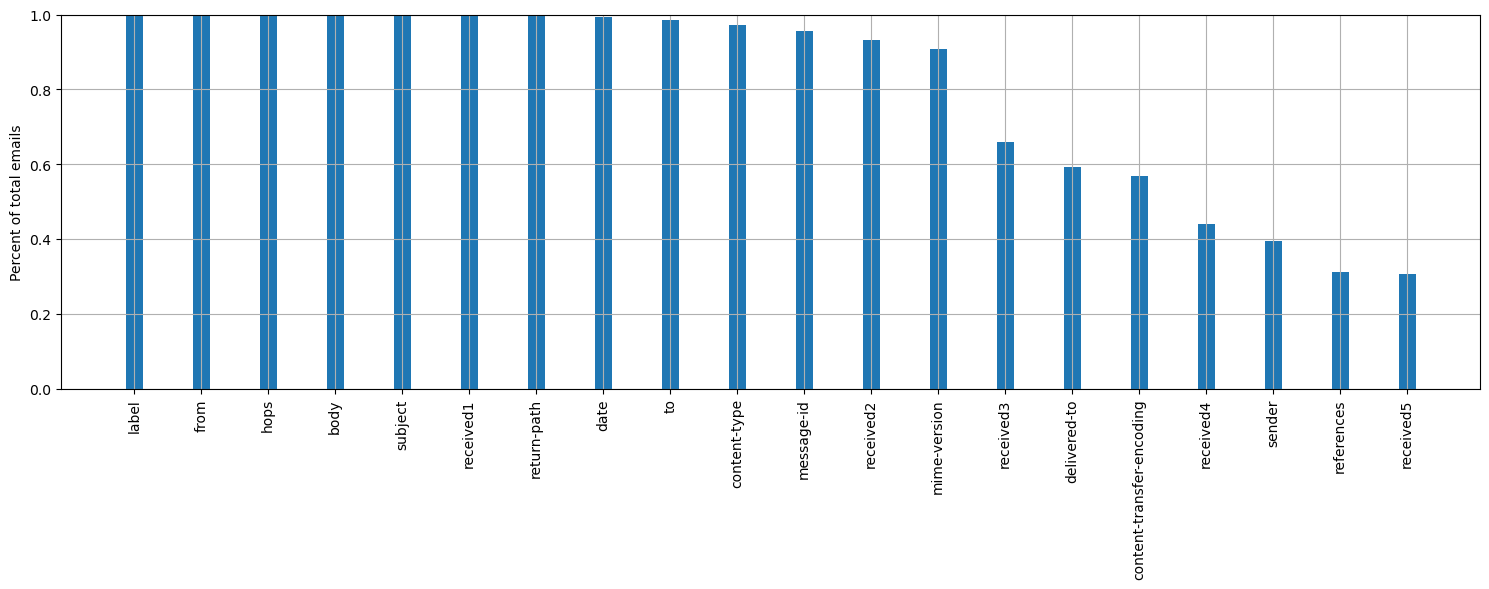

In [8]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Initialize counter for header occurrences
dict_header_features = Counter()
total_emails = 0

def countHeadersFromDataFrame(df):
    global dict_header_features, total_emails
    
    # Increment total email count
    total_emails += len(df)
    
    # Count non-null values in each column (i.e., each header)
    for column in df.columns:
        count = df[column].notnull().sum()  # Count non-null values (i.e., occurrences of this header)
        dict_header_features[column.lower()] += count

def plot_common_headers():
    global dict_header_features, total_emails
    
    # Sort the headers by frequency
    sorted_headers = sorted(dict_header_features.items(), key=lambda x: x[1], reverse=True)

    # Print header frequencies
    for header, count in sorted_headers:
        print(f"{header}: {count}")

    # Prepare data for plotting
    headers, counts = zip(*sorted_headers)
    percentages = [count / total_emails for count in counts]

    print("TOTAL EMAIL COUNT:", total_emails)

    # Plot the top 20 most common headers
    plt.figure(figsize=(15, 6))
    plt.xticks(rotation='vertical')
    plt.ylabel('Percent of total emails')
    plt.bar(headers[:20], percentages[:20], width=0.25)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('most_common_header_features.png', bbox_inches="tight")
    plt.show()

def main():
    global dict_header_features, total_emails

    # Count headers in each DataFrame
    countHeadersFromDataFrame(df_ensemble_safe_trec)
    countHeadersFromDataFrame(df_train_and_test_safe_trec)
    countHeadersFromDataFrame(df_phishingpot)
    countHeadersFromDataFrame(df_jose_phishing)

    # Plot the most common headers
    plot_common_headers()

if __name__ == '__main__':
    main()
